In [1]:
import  keras
import  tensorflow as  tf  
#print(keras.__version__)
#print(tf.__version__)

Using TensorFlow backend.


In [2]:
import numpy 
import pandas 
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import datetime
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib

# be able to save images on server
matplotlib.use('Agg')
from matplotlib import pyplot

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.


## 1. Load Dataset

In [3]:
# import all stock prices 
df = pandas.read_csv("/Users/kellyliu/Desktop/HMM/WWWWR.csv", index_col = 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, 15-01-02 to 18-11-08
Data columns (total 1 columns):
AMClose    968 non-null float64
dtypes: float64(1)
memory usage: 15.1+ KB


,AMClose
Date,
15-01-02,2.08
15-01-05,2.20
15-01-06,2.21
15-01-07,2.22
15-01-08,2.21


### 1.1 Load Dataset, covert ID to datetime

Date
2015-01-02    2.08
2015-01-05    2.20
2015-01-06    2.21
2015-01-07    2.22
2015-01-08    2.21
Name: AMClose, dtype: float64


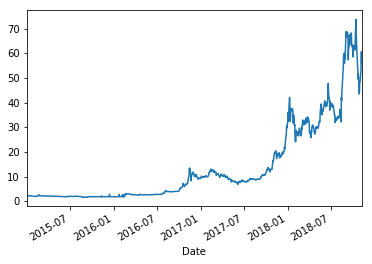

In [4]:
# load and plot dataset
from pandas import datetime
from matplotlib import pyplot

# load dataset
def parser(x):
	return datetime.strptime('20'+x, '%Y-%m-%d')
series = pandas.read_csv("/Users/kellyliu/Desktop/HMM/WWWWR.csv", header=0, 
                     parse_dates=[0], index_col=0, squeeze=True, 
                     date_parser=parser)
# summarize first few rows

print(series.head())
#line plot
series.plot()

pyplot.show()
#Running the example loads the dataset as a Pandas Series 

## Diagnostic of 100, 500, 1000 Epochs

In [5]:

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df = df.drop(0)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 

In [25]:
# run a repeated experiment
def experiment(repeats, series, epochs):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 4
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, epochs, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 
 
# load dataset
series = pandas.read_csv("/Users/kellyliu/Desktop/HMM/WWWWR.csv", header=0, 
                     parse_dates=[0], index_col=0, squeeze=True, 
                     date_parser=parser)
repeats = 2
results = DataFrame()
# vary training epochs
epochs = [100, 500, 1000 ]
for e in epochs:
	results[str(e)] = experiment(repeats, series, e)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_epochs.png')

TypeError: while_loop() got an unexpected keyword argument 'maximum_iterations'

## Larger Batch Size. 
- Explore larger batch sizes than 4, perhaps requiring further manipulation of the size of the training and test datasets.


## Diagnostic of 1,2,4, Batch Size  (with epoch=)

In [10]:
# run a repeated experiment
def experiment(repeats, series, batch_size):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, 1000, 1)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 
 
# load dataset
series = pandas.read_csv("/Users/kellyliu/Desktop/HMM/WWWWR.csv", header=0, 
                     parse_dates=[0], index_col=0, squeeze=True, 
                     date_parser=parser)
repeats = 2
results = DataFrame()
# vary training batches
batches = [1]
for b in batches:
	results[str(b)] = experiment(repeats, series, b)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_batches.png')

ValueError: In a stateful network, you should only pass inputs with a number of samples that can be divided by the batch size. Found: 952 samples

## Diagnostic of 1, 2, 3, 4, 5 neurons (epoch=1000, batch=1)

In [ ]:
 
# run a repeated experiment
def experiment(repeats, series, neurons):
	# transform data to be stationary
	raw_values = series.values
	diff_values = difference(raw_values, 1)
	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values
	# split data into train and test-sets
	train, test = supervised_values[0:-12], supervised_values[-12:]
	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)
	# run experiment
	error_scores = list()
	for r in range(repeats):
		# fit the model
		batch_size = 1
		train_trimmed = train_scaled[2:, :]
		lstm_model = fit_lstm(train_trimmed, batch_size, 1000, neurons)
		# forecast the entire training dataset to build up state for forecasting
		train_reshaped = train_trimmed[:, 0].reshape(len(train_trimmed), 1, 1)
		lstm_model.predict(train_reshaped, batch_size=batch_size)
		# forecast test dataset
		test_reshaped = test_scaled[:,0:-1]
		test_reshaped = test_reshaped.reshape(len(test_reshaped), 1, 1)
		output = lstm_model.predict(test_reshaped, batch_size=batch_size)
		predictions = list()
		for i in range(len(output)):
			yhat = output[i,0]
			X = test_scaled[i, 0:-1]
			# invert scaling
			yhat = invert_scale(scaler, X, yhat)
			# invert differencing
			yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
			# store forecast
			predictions.append(yhat)
		# report performance
		rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
		print('%d) Test RMSE: %.3f' % (r+1, rmse))
		error_scores.append(rmse)
	return error_scores
 
 
# load dataset
series = pandas.read_csv("/Users/kellyliu/Desktop/HMM/WWWWR.csv", header=0, 
                     parse_dates=[0], index_col=0, squeeze=True, 
                     date_parser=parser)
repeats = 2
results = DataFrame()
# vary neurons
neurons = [1]
for n in neurons:
	results[str(n)] = experiment(repeats, series, n)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
pyplot.savefig('boxplot_neurons.png')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
1) Test RMSE: 3.545
